12368118175954993336873755748077234817682466121860078255717375895180148736_256


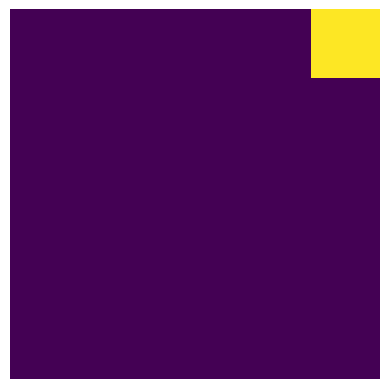

s1 := 8834451005522152103889823165890527885958343128094727151940743592599879680_256


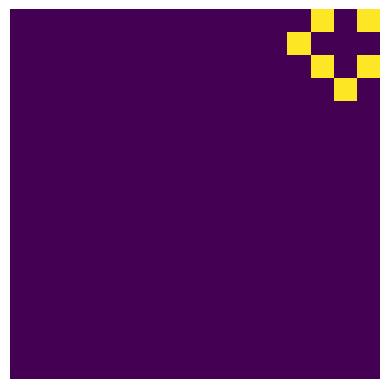

s2 := 323521828275197862815840775025680982955818540006490031031966414929920_256


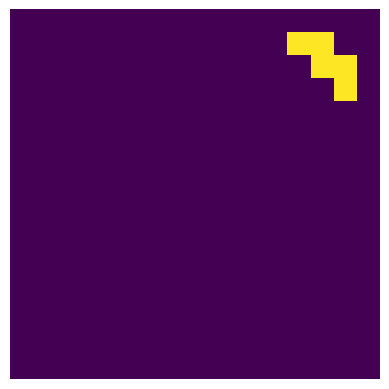

s3 := 377443367139164870552763683224245959346428477251846231351893122088960_256


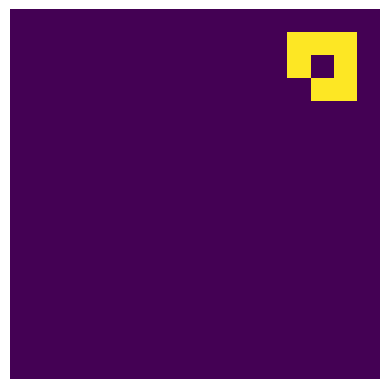

s4 := 7067657862282631741314262588055807935107249841156353550019457318014418944_256


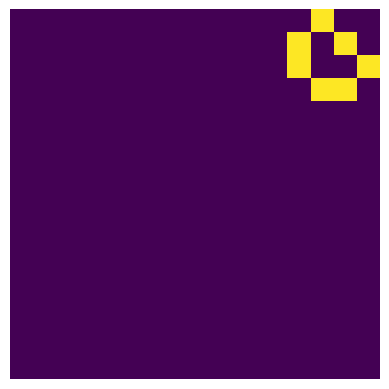

s5 := 7067657862282631741314262588055807935107249841156353550019457318014418944_256


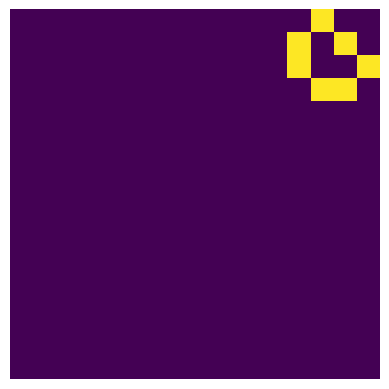

In [13]:
from pysmt.shortcuts import *
import pysmt.typing as types
import numpy as np
import random as rn
import matplotlib.pyplot as plt

n = 16     # dimensão do espaço de amostras
m = 64     # numero de amostras
p = 0

# Escolha de "solver"
#name = "msat"
name = "z3"

# Funções auxiliares para BitVec's
def bv_rn():       # gera pseudo-aleatoriamente um BitVec para representar o autómato, a partir de um inteiro
    I = 0
    c_x = np.random.randint(1, n-1)
    c_y = np.random.randint(1, n-1)
    for i in range(n-1):
        I = I | np.random.binomial(1,p) * 2**(i + n*(n-1))
    for j in range(n):
        I = I | np.random.binomial(1,p) * 2**(n*j+n-1)
    for i in range(c_x-1, c_x+2):
        for j in range(c_y-1, c_y+2):
            I = I | 2**(i+j*n)
    return BV(I,n*n)

initial = bv_rn()
print(initial)
s = list(map(int, list(initial.bv_str())))
s = [s[i:i + n] for i in range(0, len(s), n)]
plt.imshow(s)
plt.axis('off')
plt.show()

def bv_selZE(z,i,j):                    # seleciona o bit (i,j) do BitVec "z" e estende n*n-1
    return BVZExt(BVExtract(z,start=i+j*n,end=i+j*n),n*n-1)

def bv_sel(z,i,j):                    # seleciona o bit (i,j) do BitVec "z"
    return BVExtract(z,start=i+j*n,end=i+j*n)

def declare(i): #declara um bitvector de tamanho n*n
    state = Symbol('s'+str(i),types.BVType(n*n))
    return state

def trans(curr, prox): #define uma transição entre dois estados do problema
    r = []
    for i in range(n):
        for j in range(n):
            #t0 = And(Equals(bv_sel(next,i,j), Int(0)), E)
            #prox[i][j] == 1 sse curr[i][j] == 1 e s == 4 ou s == 3
            s = sum([bv_selZE(curr,a,b) for a in [i-1,i,i+1] for b in [j-1,j,j+1] if a >= 0 and a < n and b >= 0 and b < n])
            t1 = Iff(Equals(bv_sel(prox,i,j), BVOne(1)), Or(Equals(s, BV(3,n*n)), And(Equals(bv_sel(curr,i,j),BVOne(1)), Equals(s, BV(4,n*n)))))
            r.append(t1)
    return And(r)

last = initial
trace = {}
with Solver(name=name) as solver:
    i = 0
    while last not in trace:
        trace[last] = i
        i += 1
        prox = declare(len(trace))
        solver.push()
        solver.add_assertion(trans(last, prox))
        if solver.solve():
            print(solver.get_model())
            s = list(map(int,list(solver.get_value(prox).bv_str())))
            s = [s[i:i + n] for i in range(0, len(s), n)]
            plt.imshow(s)
            plt.axis('off')
            plt.show()
        else:
            print("Algo deu asneira.")
            break
        last = solver.get_value(prox)
        solver.pop()
#fazer um and para ver as condições, isto fica extremamente uma treta